# Week4 Kaggle Project Disaster Tweets

github link

https://github.com/kcwilsonii/DTSA_5511

In [138]:
from PIL import Image
import glob
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt      
from matplotlib.pyplot import figure
from sklearn.svm import SVC                                
from sklearn.model_selection import train_test_split

import pathlib
import os
import string
import warnings 

import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import math
from sklearn.metrics import accuracy_score, confusion_matrix
import time
from sklearn.cluster import KMeans
import keras
from tqdm import tqdm

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Bidirectional,Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, LSTM, CuDNNLSTM, Embedding, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant

   ## Check path Settings

In [139]:
print(pathlib.Path().absolute())
print (os.getcwd())


C:\Users\Rivendell\Documents\Data_Science_masters\Boulder_Colorado\2023_Spring_Session_2\DTSA 5511 Introduction to Deep Learning\Week_4
C:\Users\Rivendell\Documents\Data_Science_masters\Boulder_Colorado\2023_Spring_Session_2\DTSA 5511 Introduction to Deep Learning\Week_4


## set color settings for use with print statements

In [140]:
class color:
    PURPLE = "\033[95m"
    CYAN = "\033[96m"
    DARKCYAN = "\033[36m"
    BLUE = "\033[94m"
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"
    END = "\033[0m"

## Get data for Disaster tweet Kaggle set

In [141]:
current_dir = (os.getcwd())


print(color.UNDERLINE + color.BOLD + color.RED + "Disaster Tweet Data" + color.END)    
File_name = None
File_name = "\\test.csv"
print(File_name)

File_Path = current_dir + File_name
print(File_Path)
Tweet_Test_Data = pd.read_csv(File_Path)
print(Tweet_Test_Data.head())


print()
print()
print(color.UNDERLINE + color.BOLD + color.RED + "Tweet Train Data" + color.END)
File_name = None
File_name = "\\train.csv"
File_Path = current_dir + File_name
Tweet_Train_Data = pd.read_csv(File_Path)
print(Tweet_Train_Data.head())

print()
print()
print(color.UNDERLINE + color.BOLD + color.RED + "Tweet Sample Solution Data" + color.END)
File_name = None
File_name = "\\sample_submission.csv"
File_Path = current_dir + File_name
Tweet_Sample_Solution = pd.read_csv(File_Path)
print(Tweet_Sample_Solution.head())




Disaster Tweet Data
\test.csv
C:\Users\Rivendell\Documents\Data_Science_masters\Boulder_Colorado\2023_Spring_Session_2\DTSA 5511 Introduction to Deep Learning\Week_4\test.csv
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


Tweet Train Data
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfir

## Plot number of word per Training tweet target category


In [142]:
plt.rcParams["figure.figsize"] = (10,5)

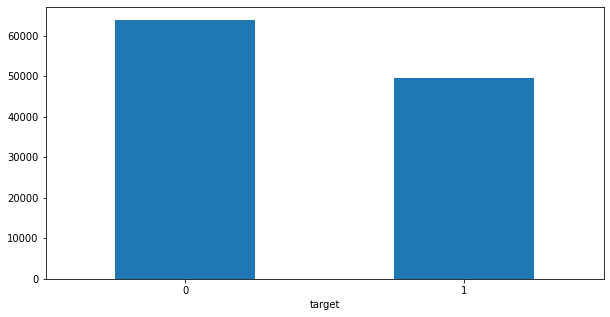

In [143]:
Tweet_Train_Data['Word_Count'] = Tweet_Train_Data["text"].str.split().apply(len) # add a new column with word counts

Train_grouped = Tweet_Train_Data.groupby(by='target')['Word_Count'].sum()
Train_grouped.plot.bar(x='Category', y='Word_Count', width = 0.5)
plt.xticks(rotation='horizontal')
plt.show()


## Plot count of Training Target Values

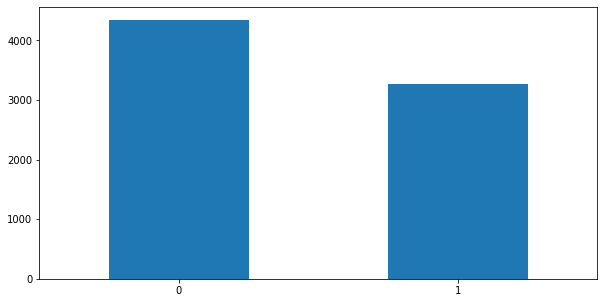

In [144]:
Tweet_Train_Data['target'].value_counts().plot.bar()
plt.xticks(rotation='horizontal')
plt.show()

## check sample solution file target value

In [9]:

print(Tweet_Sample_Solution["target"].unique())


[0]


## Consolidate all the text from train and test into one dataframe for overall use and check data split between sets

In [11]:
All_Tweets = pd.concat([Tweet_Train_Data["text"], Tweet_Test_Data["text"]], axis=0)  

In [12]:
Train_length = len(Tweet_Train_Data["text"])
Test_length = len(Tweet_Test_Data["text"])
Total_Length = len(All_Tweets)
Train_percent = (Train_length/Total_Length)*100
Test_percent = (Test_length/Total_Length)*100
print("Train Percent: ",'%.2f' % Train_percent,"%")
print("Test Percent: ",'%.2f' % Test_percent,"%")
All_Tweets.head()

Train Percent:  70.00 %
Test Percent:  30.00 %


0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

## Function to remove unwanted text and stop words. 
## This will be used to reduce the tweets to a meaningful set of words which should help in predicting each tweet better

In [13]:
def Text_Removal(Text_Dataframe, Text_Column_Name):
    
    # Function to reduce text to a usable set of words for identifying topics
    # and the article category
    
    Word_Data = Text_Dataframe.copy()
    #remove unecessary punction and text that do not qualify as words
    Word_Data[Text_Column_Name] = Word_Data[Text_Column_Name].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    Word_Data[Text_Column_Name] = Word_Data[Text_Column_Name].apply(lambda row: re.sub(r'[0-9]+', '', row))
    
    #remove stopwords or words that are not unique  like... (the, and, or , that)
    stop_words = stopwords.words('english')
    Word_Data[Text_Column_Name] = Word_Data[Text_Column_Name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    return Word_Data[Text_Column_Name]

## Remove unwanted text from Train Data and Test data with Text_Removal function

In [14]:
warnings.simplefilter('ignore')


Train_Cleaned_Text_Series = Text_Removal(Tweet_Train_Data,"text")
Train_Cleaned_Text = pd.DataFrame({'id':Train_Cleaned_Text_Series.index, 'text':Train_Cleaned_Text_Series.values})

Test_Cleaned_Text_Series = Text_Removal(Tweet_Test_Data,"text")
Test_Cleaned_Text = pd.DataFrame({'id':Test_Cleaned_Text_Series.index, 'text':Test_Cleaned_Text_Series.values})

# get target values matched back up to cleaned text
Train_Cleaned_Text = Train_Cleaned_Text.drop(['id'], axis=1)
Tweet_Train_Data2 = Tweet_Train_Data.copy()
Tweet_Train_Data2 = Tweet_Train_Data2.drop(['id', 'keyword', 'location','text','Word_Count'], axis=1)

Tweets_Train_Final = pd.concat([Train_Cleaned_Text, Tweet_Train_Data2],axis=1)

#Tweets_Train_Final = pd.DataFrame({'id':Test_Cleaned_Text_Series.index, 'text':Test_Cleaned_Text_Series.values})



## Prepare the data for use with RNN model

In [15]:
print(Tweets_Train_Final.head())
print(Tweets_Train_Final.info())

Tweets_train = Tweets_Train_Final['text'].values
Tweets_test = Test_Cleaned_Text['text'].values

tokenizer = Tokenizer()

tokenizer.fit_on_texts(All_Tweets)

Tweet_Length = max(len(x.split()) for x in All_Tweets)
print('Tweet Length : ', Tweet_Length)

Train_Sequences = tokenizer.texts_to_sequences(Tweets_train)
Train_padded = pad_sequences(Train_Sequences, maxlen=Tweet_Length)

Test_Sequences = tokenizer.texts_to_sequences(Tweets_test)
Test_padded = pad_sequences(Test_Sequences, maxlen=Tweet_Length)


X_train,X_validate,Y_train,Y_validate = train_test_split(Train_padded, Tweets_Train_Final['target'].values, test_size = 0.3, random_state = 0)

# This is used for Embedding layer afterwards
Train_Word_Count = len(tokenizer.word_index) + 1
print(Train_Word_Count)

                                                text  target
0   Our Deeds Reason earthquake May ALLAH Forgive us       1
1              Forest fire near La Ronge Sask Canada       1
2  All residents asked shelter place notified off...       1
3  people receive wildfires evacuation orders Cal...       1
4  Just got sent photo Ruby Alaska smoke wildfire...       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
None
Tweet Length :  31
29320


## Setup Model for learning
### I tried multiple combinations of LSTM, Layers and Dropouts for the model setup with little variation between them with respect to the final Kaggle Submission. This seemed to over fit rather quickly causing issues with the validation accuracy over each epoch. I would probably have to look at some more specialized techniques for this type of data, some of which used embedded dictionary and glove files to help with the embedding.

### The model below performed the best and kept learning over more than just 2 epochs. I simplified the LSTM as the others were overfitting too quickly and not improving the performance at all


In [131]:
# Long Short Term Memory network.
input_length_value = Tweet_Length

hidden_units = 128
embed_units = 10

RNN_model = Sequential()
RNN_model.add(Embedding(Train_Word_Count, embed_units, input_length = input_length_value))

#RNN_model.add(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
RNN_model.add(LSTM(units=50))
#RNN_model.add(Bidirectional(LSTM(hidden_units)))

#RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(64, activation='relu'))
RNN_model.add(Dropout(0.1))
RNN_model.add(Dense(1, activation='sigmoid'))

Optimizer1 = Adam(learning_rate=0.001)

RNN_model.compile(optimizer=Optimizer1, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['accuracy'])
#RNN_model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

RNN_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 31, 10)            293200    
                                                                 
 lstm_39 (LSTM)              (None, 50)                12200     
                                                                 
 dense_72 (Dense)            (None, 64)                3264      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_73 (Dense)            (None, 1)                 65        
                                                                 
Total params: 308,729
Trainable params: 308,729
Non-trainable params: 0
_________________________________________________________________


## Fitted Model
### I ended up using a batch size and epoch range similar to the week 3 project as it again worked well. Shuffle was set to to true, but I found that this time around the fit after it was run was retaining information from the previous run. I would change the number of epochs and it would overfit within 2 epochs and accuracy score was at approximately 0.98 almost immediately

In [132]:
batch_size = 512
Epoch_Count = 8

RNN_model_history = RNN_model.fit(X_train, Y_train, 
                          shuffle = True,
                          validation_split=0.2,
                          batch_size = batch_size, 
                          epochs = Epoch_Count 
                          )

Epoch 1/8
9/9 [==============================] - 3s 215ms/step - loss: 0.6890 - accuracy: 0.5599 - val_loss: 0.6793 - val_accuracy: 0.5750
Epoch 2/8
9/9 [==============================] - 1s 159ms/step - loss: 0.6799 - accuracy: 0.5609 - val_loss: 0.6717 - val_accuracy: 0.5750
Epoch 3/8
9/9 [==============================] - 1s 158ms/step - loss: 0.6665 - accuracy: 0.5609 - val_loss: 0.6540 - val_accuracy: 0.5797
Epoch 4/8
9/9 [==============================] - 1s 159ms/step - loss: 0.6295 - accuracy: 0.6205 - val_loss: 0.6158 - val_accuracy: 0.6745
Epoch 5/8
9/9 [==============================] - 1s 149ms/step - loss: 0.5663 - accuracy: 0.7645 - val_loss: 0.5712 - val_accuracy: 0.7326
Epoch 6/8
9/9 [==============================] - 1s 154ms/step - loss: 0.4640 - accuracy: 0.8285 - val_loss: 0.5449 - val_accuracy: 0.7270
Epoch 7/8
9/9 [==============================] - 1s 157ms/step - loss: 0.3592 - accuracy: 0.8707 - val_loss: 0.5195 - val_accuracy: 0.7627
Epoch 8/8
9/9 [============

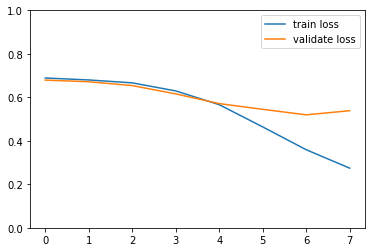

<Figure size 432x288 with 0 Axes>

In [133]:
plt.plot(RNN_model_history.history['loss'], label='train loss')
plt.plot(RNN_model_history.history['val_loss'], label='validate loss')
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()
plt.savefig('Loss_Comparison')

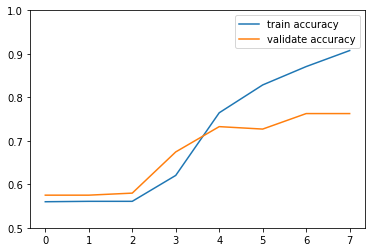

<Figure size 432x288 with 0 Axes>

In [134]:
plt.plot(RNN_model_history.history['accuracy'], label='train accuracy')
plt.plot(RNN_model_history.history['val_accuracy'], label='validate accuracy')
plt.ylim(0.5, 1.0)
plt.legend()
plt.show()
plt.savefig('Accuracy_Comparison')

## Predict test values

In [135]:
RNN_Predict = RNN_model.predict(Test_padded)

102/102 [==============================] - 1s 4ms/step


In [136]:
print(len(RNN_Predict))
print(type(RNN_Predict))
print(RNN_Predict)

3263
<class 'numpy.ndarray'>
[[0.5445302 ]
 [0.5950188 ]
 [0.8895033 ]
 ...
 [0.74240845]
 [0.87798476]
 [0.8460838 ]]


## Code to create file for Kaggle submission
### This submission required the final values be either 1 or 0 so the predicted values are rounded to an INT type and the test data set's "target" field set equal to that.

In [137]:
Tweet_Submission = Tweet_Test_Data.copy()
Tweet_Submission['target'] = np.round(RNN_Predict).astype(int)
Tweet_Submission = Tweet_Submission.drop(['keyword', 'location','text'], axis=1)
print(Tweet_Submission.head())

Tweet_Submission.to_csv('Tweet_Kaggle_submission_Simple_LSTM_8.csv', index=False)



   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
